In [1]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input


# from google.colab import drive
# drive.mount("/content/gdrive")

Using TensorFlow backend.


In [2]:
import keras
print(keras.__version__)

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

2.2.4
['/job:localhost/replica:0/task:0/device:GPU:0']


In [3]:
drive_base_path = "../"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_balanced_images = drive_base_path + "dataset/ISIC2018_Balanced_Training_Input/"
# path_to_description = drive_base_path + "dataset/ISIC2018_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

In [4]:
def load_sample(path_to_images, number_of_images):
    list_of_images = os.listdir(path_to_images)
    x = []
    for i, filename in enumerate(list_of_images):
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x.append(image)
        
        if i >= number_of_images:
            break
    
    x = np.array(x)
    return x       

In [5]:
x = load_sample(path_to_images, 1000)
print(x.shape)

(1001, 450, 600, 3)


In [6]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    data_format="channels_last")

In [7]:
datagen.fit(x)

In [9]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
train_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=32,
                    classes=classes,
                    shuffle=True)

Found 32404 images belonging to 7 classes.


In [10]:
samples = train_generator.samples

In [11]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

[1.0397895  0.69040162 1.28658779 1.08895386 1.05303523 1.0063354
 1.05159992]


# DEFINING THE MODEL

In [12]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

model.compile(loss="categorical_crossentropy", 
              optimizer=RMSprop(lr=1e-4), 
              metrics=["acc"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
batch_size = 32
epochs = 5
history = model.fit_generator(train_generator, 
                              epochs=epochs,
#                               class_weight=class_weights,
                              steps_per_epoch=samples / batch_size,
                              verbose=1)

Epoch 1/5
1013/1012 [==============================] - 551s 544ms/step - loss: 1.2093 - acc: 0.5750
Epoch 2/5
1013/1012 [==============================] - 549s 542ms/step - loss: 0.6944 - acc: 0.7368
Epoch 4/5
1013/1012 [==============================] - 549s 542ms/step - loss: 0.6385 - acc: 0.7590
Epoch 5/5
1013/1012 [==============================] - 549s 542ms/step - loss: 0.5948 - acc: 0.7781


In [14]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True

# for layer in model.layers:
#     print(layer, layer.trainable)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_1
20 dense_1
21 dense_2
22 dense_3


In [ ]:
model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=["acc"])
epochs = 20
batch_size = 32
history = model.fit_generator(train_generator, 
                              steps_per_epoch=samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1)
model.save_weights(drive_base_path + 'models/VGG16_AUG_ISIC_cnn.h5')
# model.evaluate(X_test, y_test)

Epoch 1/20
1013/1012 [==============================] - 551s 544ms/step - loss: 0.4826 - acc: 0.8188
Epoch 2/20
1013/1012 [==============================] - 551s 543ms/step - loss: 0.3705 - acc: 0.8593
Epoch 3/20
1013/1012 [==============================] - 550s 543ms/step - loss: 0.3183 - acc: 0.8807
Epoch 4/20
1013/1012 [==============================] - 550s 543ms/step - loss: 0.2908 - acc: 0.8894
Epoch 5/20
1013/1012 [==============================] - 550s 543ms/step - loss: 0.2603 - acc: 0.9001
Epoch 6/20
1013/1012 [==============================] - 549s 542ms/step - loss: 0.2432 - acc: 0.9072
Epoch 7/20
1013/1012 [==============================] - 550s 542ms/step - loss: 0.2114 - acc: 0.9192
Epoch 8/20
1013/1012 [==============================] - 549s 542ms/step - loss: 0.1986 - acc: 0.9254
Epoch 9/20
1013/1012 [==============================] - 550s 543ms/step - loss: 0.1774 - acc: 0.9342
Epoch 10/20
 276/1012 [=======>......................] - ETA: 6:39 - loss: 0.1647 - acc: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1013/1012 [==============================] - 550s 543ms/step - loss: 0.1631 - acc: 0.9385
Epoch 11/20
 542/1012 [===============>..............] - ETA: 4:15 - loss: 0.1570 - acc: 0.9414

# ACCURACY AND LOSS PLOTS

dict_keys(['loss', 'acc'])


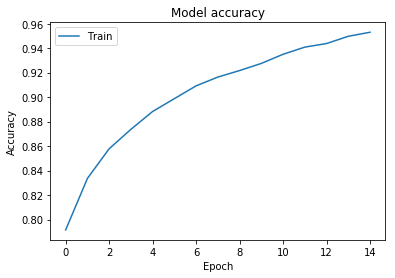

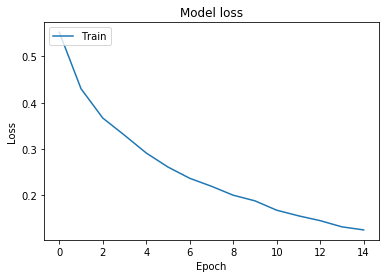

In [15]:
# Plot Training and Validation Accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CONFUSION MATRIX

In [67]:
def load_sample(path_to_images, number_of_images):
    list_of_images = os.listdir(path_to_images)
    x = []
    for i, filename in enumerate(tqdm(list_of_images)):
        image = cv2.imread(path_to_images + filename)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x.append(image)
        
        if i >= number_of_images:
            break
    
    x = np.array(x)
    return x

In [68]:
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
x = load_sample(path_to_images, 5000)

In [69]:
print(x.shape)

(5001, 450, 600, 3)


In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

testgen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

testgen.fit(x[:1000])

classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
test_generator = testgen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=1,
                    classes=classes,
                    shuffle=False)

y_pred = model.predict_generator(test_generator, steps=len(x))

Found 32404 images belonging to 7 classes.


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

# ISIC LIVE IMAGE TEST/VALIDATION DATA

In [20]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Test_Input/"

In [21]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    path_to_images = path_to_images + 'test/'
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (input_size, input_size))

        arr = np.array(image)
        images_list.append(image)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [22]:
x_test, names = preprocess_images(path_to_images)

In [24]:
print(x_test.shape)
print(names.shape)

(1512, 224, 224, 3)
(1512, 1)


In [25]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [27]:
datagen.fit(x_test)

In [28]:
test_generator = datagen.flow(
                    x_test,
                    batch_size=1,
                    shuffle=False)

In [30]:
model.load_weights(drive_base_path + 'models/VGG16_AUG_ISIC_cnn.h5')

In [32]:
predictions = model.predict_generator(test_generator, steps=len(x_test))
# classes = (predictions > 0.5).astype(np.float)
# print(classes.shape)

In [33]:
print(predictions.shape)

(1512, 7)


In [34]:
final_output = np.concatenate((names, predictions), axis=1)
final_output.shape

(1512, 8)

In [35]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)